<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6회차: DNN을 활용한 심장병 판별 (4) – 모델 최적화

## 1. DNN 학습 최적화


In [ ]:
!pip show imbalanced-learn

Name: imbalanced-learn
Version: 0.14.0
Summary: Toolbox for imbalanced dataset in machine learning
Home-page: https://imbalanced-learn.org/
Author: 
Author-email: "G. Lemaitre" <g.lemaitre58@gmail.com>, "C. Aridas" <ichkoar@gmail.com>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


In [ ]:
# !pip install imbalanced-learn # Colab에서는 필요 없음

In [2]:
# 라이브러리
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [3]:
# 1. 데이터 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

### 오버샘플링을 위한 SMOTE 함수

In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 간단한 샘플 데이터를 통한 SMOTE의 이해
X = [[i] for i in range(50)]
y = [0]*40 + [1]*10

print("Before SMOTE:", Counter(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("After SMOTE :", Counter(y_res))

Before SMOTE: Counter({0: 40, 1: 10})
After SMOTE : Counter({0: 40, 1: 40})


In [25]:
# 4. SMOTE로 샘플링 (소수 클래스 보완)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [26]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_resampled))

Counter({np.float32(0.0): 131, np.float32(1.0): 111})
Counter({np.float32(1.0): 131, np.float32(0.0): 131})


### 다시 한번 위 코드 정리

In [32]:
# 라이브러리
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# 1. 데이터 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

# 4. SMOTE로 샘플링 (소수 클래스 보완)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [33]:
# 5-1. Dataset 클래스 정의: 테스트 데이터를 위해
class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [34]:
# 5-2. 혼합 증강 클래스(원본 데이터 + 노이즈 데이터: num_augments) 정의
class MixedAugmentedDataset(Dataset):
    # noise_std: 증강 강도 조절 파라미터로 변형된 원본 데이터에 약간의 노이즈 추가(곱셈)로 다양성 확보
	  # num_augments: 추가되는 수, 1이면 원 데이터 수와 동일한 수의 데이터를 추가
    def __init__(self, X, y, noise_std=0.03, num_augments=1):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        self.noise_std = noise_std
        self.num_augments = num_augments

        self.X_all, self.y_all = self._combine_original_and_augmented()

    def _combine_original_and_augmented(self):
        X_list = [self.X[i] for i in range(len(self.X))]   # 원본 포함
        y_list = [self.y[i] for i in range(len(self.y))]

        # 데이터셋의 각 샘플 X[i]에 대해 반복
        for i in range(len(self.X)):
            # 각 샘플에 대해 num_augments 횟수만큼 데이터 증강 수행
            for _ in range(self.num_augments):
                # 원본 데이터에 정규분포 노이즈(표준정규분포 * noise_std)를 더해 변형 데이터 생성
                noisy = self.X[i] + torch.randn_like(self.X[i]) * self.noise_std
                # 증강된 데이터를 입력 데이터 리스트에 추가
                X_list.append(noisy)
                # 원본 데이터의 라벨을 그대로 정답 리스트에 추가 (데이터는 변형돼도 라벨은 동일)
                y_list.append(self.y[i])

        return X_list, y_list

    def __len__(self):
        return len(self.y_all)

    def __getitem__(self, idx):
        return self.X_all[idx], self.y_all[idx]

In [35]:
# 학습 데이터: 데이터 증강
train_dataset = MixedAugmentedDataset(X_resampled, y_resampled)
# 테스트 데이터: 원본 데이터 그대로
test_dataset = HeartDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
# 6. DNN 모델 정의를 유연하게 정의
class DNN_Variant(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        layers = []
        # input_dim → hidden_dim 연결
        for dim in hidden_dims:
            layers += [
                nn.Linear(input_dim, dim), # 선형 변환 (Fully Connected)
                nn.BatchNorm1d(dim),       # 배치 정규화 → 학습 안정화
                nn.ReLU(),                 # 비선형 활성화 → 복잡한 함수 근사
                nn.Dropout(0.3)            # 30% 확률로 뉴런 끄기 → 과적합 방지
            ]
            # 이후 다음 레이어에서는 input_dim = dim으로 갱신해서 이어짐
            input_dim = dim
        # 마지막 출력은 이진 분류이므로 노드 1개 (시그모이드는 이후에 적용됨)
        layers += [nn.Linear(input_dim, 1)]
        # 앞서 만든 레이어 리스트를 하나의 순차적 블록으로 구성
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [37]:
# 구조 변경 모델 생성
# 은닉층 1개, 뉴런 수 64 실험
# model = DNN_Variant(input_dim=X.shape[1], hidden_dims=[64]) # 1층
# 은닉층 2개, 뉴런 수 128, 64 실험
model = DNN_Variant(input_dim=X.shape[1], hidden_dims=[128, 64]) # 2층
# 은닉층 3개, 뉴런 수 256, 128, 64 실험
# model = DNN_Variant(input_dim=X.shape[1], hidden_dims=[256, 128, 64]) # 3층

In [38]:
# 7. 손실함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
# 옵티마이저 변경
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# 스케쥴러 변경
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

In [39]:
# 8. 학습 루프
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Epoch 10 | Loss: 0.3004
Epoch 20 | Loss: 0.2272
Epoch 30 | Loss: 0.1905
Epoch 40 | Loss: 0.1524
Epoch 50 | Loss: 0.1537


In [40]:
# 9. 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

In [41]:
# 10. 결과 출력
print("=== 6강 Evaluation Metrics ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

=== 6강 Evaluation Metrics ===
Accuracy : 0.8852
Precision: 0.8182
Recall   : 0.9643
F1 Score : 0.8852


### 수업 종료

# 6회 전체 코드(오버샘플, 원본 데이터 + 노이즈 데이터)

In [ ]:
# 라이브러리
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# 1. 데이터 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

# 5. SMOTE로 샘플링 (소수 클래스 보완)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 6-1. Dataset 클래스 정의: 테스트 데이터를 위해
class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 6-2. 혼합 증강 클래스(원본 데이터 + 노이즈 데이터: num_augments) 정의
class MixedAugmentedDataset(Dataset):
    def __init__(self, X, y, noise_std=0.03, num_augments=1):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        self.noise_std = noise_std
        self.num_augments = num_augments

        self.X_all, self.y_all = self._combine_original_and_augmented()

    def _combine_original_and_augmented(self):
        X_list = [self.X[i] for i in range(len(self.X))]   # 원본 포함
        y_list = [self.y[i] for i in range(len(self.y))]

        for i in range(len(self.X)):
            for _ in range(self.num_augments):
                noisy = self.X[i] + torch.randn_like(self.X[i]) * self.noise_std
                X_list.append(noisy)
                y_list.append(self.y[i])

        return X_list, y_list

    def __len__(self):
        return len(self.y_all)

    def __getitem__(self, idx):
        return self.X_all[idx], self.y_all[idx]

# 학습 데이터: 데이터 증강
train_dataset = MixedAugmentedDataset(X_resampled, y_resampled)
# 테스트 데이터: 원본 데이터 그대로
test_dataset = HeartDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 7. DNN 모델 정의를 유연하게 정의
class DNN_Variant(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        layers = []
        # input_dim → hidden_dim 연결
        for dim in hidden_dims:
            layers += [
                nn.Linear(input_dim, dim), # 선형 변환 (Fully Connected)
                nn.BatchNorm1d(dim),       # 배치 정규화 → 학습 안정화
                nn.ReLU(),                 # 비선형 활성화 → 복잡한 함수 근사
                nn.Dropout(0.3)            # 30% 확률로 뉴런 끄기 → 과적합 방지
            ]
            # 이후 다음 레이어에서는 input_dim = dim으로 갱신해서 이어짐
            input_dim = dim
        # 마지막 출력은 이진 분류이므로 노드 1개 (시그모이드는 이후에 적용됨)
        layers += [nn.Linear(input_dim, 1)]
        # 앞서 만든 레이어 리스트를 하나의 순차적 블록으로 구성
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 구조 변경 모델 생성
# 은닉층 1개, 뉴런 수 64 실험
# model = DNN_Variant(input_dim=X.shape[1], hidden_dims=[64]) # 1층
# 은닉층 2개, 뉴런 수 128, 64 실험
model = DNN_Variant(input_dim=X.shape[1], hidden_dims=[128, 64]) # 2층
# 은닉층 3개, 뉴런 수 256, 128, 64 실험
# model = DNN_Variant(input_dim=X.shape[1], hidden_dims=[256, 128, 64]) # 3층

# 8. 손실함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
# 옵티마이저 변경
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# 스케쥴러 변경
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


# 8. 학습 루프
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

# 9. 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# 10. 결과 출력
print("=== 6강 Evaluation Metrics ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

Epoch 10 | Loss: 0.2716
Epoch 20 | Loss: 0.1998
Epoch 30 | Loss: 0.1600
Epoch 40 | Loss: 0.1257
Epoch 50 | Loss: 0.1361
=== 6강 Evaluation Metrics ===
Accuracy : 0.8689
Precision: 0.8125
Recall   : 0.9286
F1 Score : 0.8667


## (추가학습) SMOTE 데이터 시각화

In [ ]:
# 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
train_dataset[0]

(tensor([-0.6953,  1.0034, -0.4816,  0.5025,  0.0473,  0.6734,  0.0766, -0.4726,
         -0.7560, -0.0414,  0.0191,  0.0130,  0.9642,  0.0222,  0.0406,  0.9865,
         -0.0406,  1.0585,  0.0189, -0.0148, -0.0059,  0.9862]),
 tensor([1.]))

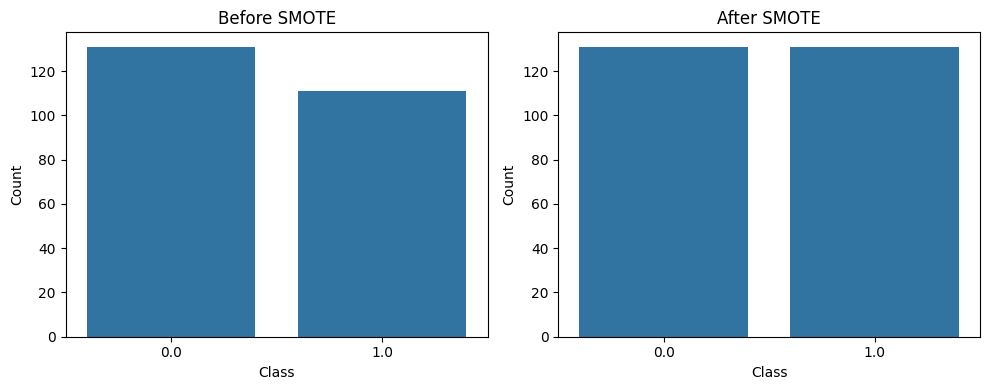

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. 오버샘플링 전 클래스 분포 확인
def plot_class_distribution(y_data, title, subplot_idx):
    counter = Counter(y_data)
    labels = list(counter.keys())
    counts = list(counter.values())
    plt.subplot(1, 2, subplot_idx)
    sns.barplot(x=labels, y=counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")

# 2. 오버샘플링 전 분포 시각화
plt.figure(figsize=(10, 4))
plot_class_distribution(y_train, "Before SMOTE", 1)

# 3. SMOTE 적용
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 4. 오버샘플링 후 분포 시각화
plot_class_distribution(y_resampled, "After SMOTE", 2)

plt.tight_layout()
plt.show()


## 종료